
# Week 2 — Baseline Prediction Models & Evaluation

In this notebook, you will build **baseline prediction models** for financial
returns and evaluate them using **strictly forward-looking (time-series)
validation**.

This week focuses on **evaluation discipline**, not on maximizing performance.


## 1. Imports

In [54]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

plt.style.use("seaborn-v0_8")



## 2. Load data from Week 1

- Reuse the data you created in Week 1.
- You can use one stock of your choice (you can repeat it for multiple stocks if you want and plot them separately)
- Take a long term horizon data set (5-10 years)


In [55]:
# TODO: load prices and returns from Week 1
import yfinance as yf

long_amzn = pd.DataFrame(
    yf.download(['AMZN'], start='2015-01-01', end='2024-01-01', auto_adjust=False)
    ).xs('AMZN', level=1, axis=1)['Adj Close'].ffill().bfill()

long_amzn

[*********************100%***********************]  1 of 1 completed


Date
2015-01-02     15.426000
2015-01-05     15.109500
2015-01-06     14.764500
2015-01-07     14.921000
2015-01-08     15.023000
                 ...    
2023-12-22    153.419998
2023-12-26    153.410004
2023-12-27    153.339996
2023-12-28    153.380005
2023-12-29    151.940002
Name: Adj Close, Length: 2264, dtype: float64


## 3. Feature construction

Required features:
- $r_t$
- $r_{t-1}$
- 20-day rolling mean
- 20-day rolling volatility
- 5-day momentum


In [56]:
# TODO: construct features using only past data
log_rets = np.log(long_amzn).diff().dropna()
prev_log_rets = log_rets.shift(1).dropna()
mean20 = log_rets.rolling(20).mean().dropna()
volt20 = log_rets.rolling(20).std().dropna()
momen5 = log_rets.rolling(5).sum().dropna()
target = log_rets.shift(-1).dropna()

all_data = pd.concat(
    {
        "log rets": log_rets,
        "prev log rets": prev_log_rets,
        "roll mean": mean20,
        "roll volt": volt20,
        "momentum": momen5,
        "target": target,
    },
    axis=1,
).dropna()
all_data

,log rets,prev log rets,roll mean,roll volt,momentum,target
Date,,,,,,
2015-02-02,0.027651,0.128495,0.008333,0.033897,0.162969,-0.002527
2015-02-03,-0.002527,0.027651,0.009243,0.033315,0.169884,0.003295
2015-02-04,0.003295,-0.002527,0.010563,0.032479,0.182481,0.024749
2015-02-05,0.024749,0.003295,0.011273,0.032634,0.181664,0.001043
2015-02-06,0.001043,0.024749,0.010984,0.032701,0.054211,-0.009989
...,...,...,...,...,...,...
2023-12-21,0.011243,-0.010918,0.002373,0.011820,0.042627,-0.002734
2023-12-22,-0.002734,0.011243,0.002226,0.011866,0.022744,-0.000065
2023-12-26,-0.000065,-0.002734,0.001886,0.011828,-0.004293,-0.000456


In [57]:
xt = all_data.drop(columns='target').to_numpy()
yt = all_data['target'].to_numpy()
print(xt, "\nShape: ", xt.shape)
print(yt, "\nShape: ", yt.shape)

[[ 2.76512614e-02  1.28495149e-01  8.33287786e-03  3.38973562e-02
   1.62969296e-01]
 [-2.52737851e-03  2.76512614e-02  9.24304362e-03  3.33152963e-02
   1.69883768e-01]
 [ 3.29531906e-03 -2.52737851e-03  1.05627122e-02  3.24790368e-02
   1.82480516e-01]
 ...
 [-6.51468682e-05 -2.73383088e-03  1.88639227e-03  1.18276512e-02
  -4.29299240e-03]
 [-4.56445480e-04 -6.51468682e-05  2.10105075e-03  1.17395061e-02
  -2.93033755e-03]
 [ 2.60879923e-04 -4.56445480e-04  2.35612400e-03  1.16357044e-02
   8.24888321e-03]] 
Shape:  (2243, 5)
[-0.00252738  0.00329532  0.02474949 ... -0.00045645  0.00026088
 -0.00943281] 
Shape:  (2243,)


In [58]:
# from typing import Any

# def eval_model_fit_pow(real_data: pd.Series, predicted_data: pd.Series | np.ndarray) -> dict[Any, Any]:
#     errors = real_data - predicted_data
#     mse = (errors.dropna()**2).mean()
#     rmse = np.sqrt(mse)
#     return {'MSE' : mse, 'RMSE' : rmse}

# def display_results(output: dict[Any, Any]) -> None:
#     print('''Calculated Statistics:
# =======================''')
#     for attr, val in output.items():
#         print(f"{attr:5} = {val}")


## 4. Naive baselines


In [59]:
# TODO: zero predictor
def zero_baseline(test_x, *, test_y=None, train_x=None, train_y=None):
    return np.zeros(len(test_x))

In [60]:
# TODO: rolling mean predictor
def roll_mean_baseline(test_x, width: int=10, *, test_y=None, train_x=None, train_y=None):
    if train_y is None:
        train_y = np.array([])
    if test_y is None:
        return np.full(len(test_x), np.mean(train_y[-width:]))
    history = list(train_y[-width:])
    out = []
    for i in range(len(test_y)):
        pred_ = np.mean(history[-width:]) if len(history) >= width else 0.0
        history.append(test_y[i])
        out.append(pred_)
    return pd.Series(out)
    # return pd.Series(test_y).rolling(width).mean().dropna()

roll_mean_baseline(log_rets, 10)

/home/bhavya/Desktop/Projects/WIDS/Predict2Optimize-WiDS-2025-fork/P2O/lib64/python3.14/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/bhavya/Desktop/Projects/WIDS/Predict2Optimize-WiDS-2025-fork/P2O/lib64/python3.14/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


array([nan, nan, nan, ..., nan, nan, nan], shape=(2263,))


## 5. Linear models (OLS & Ridge)
Suggested that you review basic linear regression theory as well (resources given in README).

In [61]:
# use LinearRegression from sklearn
def linear_predictor(test_x, *, test_y=None, train_x, train_y):
    lr = LinearRegression()
    model = lr.fit(X=train_x, y=train_y)
    return model.predict(test_x)


In [62]:
from sklearn.linear_model import Ridge

def ridge_predictor(test_x, *, test_y=None, train_x, train_y):
    ALPHA = 0.1
    ridge = Ridge(alpha=ALPHA)
    model = ridge.fit(X=train_x, y=train_y)
    return model.predict(test_x)

# print(sorted(np.linspace(0, 1, 100), key=lambda x: evaluate_prediction(yt, Ridge(alpha=x).fit(xt, yt).predict(xt)).get('MSE')))


## 6. Tree-based model (Random Forest) (optional)


In [63]:
def rf_predictor(test_x, *, test_y=None, train_x, train_y):
    rf = RandomForestRegressor(
        n_estimators=100,
        max_depth=5,
        min_samples_leaf=50,
        random_state=42
    )
    model = rf.fit(X=train_x, y=train_y)
    return model.predict(test_x)

## 7. Walk-forward evaluation

- Scikit reference for [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html).

In [64]:
# TODO: implement TimeSeriesSplit evaluation
# Docs state that the split is deterministic

def eval_predictor(*, predictor, xt, yt, name, nsplit=5):
    ts = TimeSeriesSplit(n_splits=nsplit)
    if len(xt) != len(yt):
        raise ValueError(f"xt has length {len(xt)} while yt has length {len(yt)}")
    
    total_sse = 0
    total_n   = 0
    
    print(f'Model {name}')
    for i, (train_idx, test_idx) in enumerate(ts.split(xt)):
        tr_x = xt[train_idx]
        tr_y = yt[train_idx]
        test_x  = xt[test_idx]
        test_y  = yt[test_idx]
        
        predictions = predictor(test_x=test_x, test_y=test_y, train_x=tr_x, train_y=tr_y)
        if len(predictions) != len(test_y):
            test_y = test_y[-len(predictions):]
        errors = predictions - test_y
        sse = np.dot(errors, errors)
        n = len(errors)
        
        total_sse += sse
        total_n   += n
        
        print(f'\tSample {i}:')
        print(f'\t\tRMSE = {np.sqrt(sse / n)}')
    
    print('\t+=========+')
    print('\t| Summary |')
    print('\t+=========+')
    print(f'\t\tRMSE = {np.sqrt(total_sse / total_n)}\n')
        
        


## 8. Prediction accuracy


In [65]:
predictors = [
    ("Zero",          zero_baseline),
    ("Rolling mean",  roll_mean_baseline),
    ("Linear",        linear_predictor),
    ("Ridge",         ridge_predictor),
    ("Random forest", rf_predictor),
]
# TODO: compute RMSE for all models and compare them
for name, pred in predictors:
    eval_predictor(predictor=pred, name=name, xt=xt, yt=yt)

Model Zero
	Sample 0:
		RMSE = 0.013190752889653344
	Sample 1:
		RMSE = 0.02091267805857225
	Sample 2:
		RMSE = 0.021129721566613843
	Sample 3:
		RMSE = 0.02328590499127557
	Sample 4:
		RMSE = 0.023934815794303146
	+=========+
	| Summary |
	+=========+
		RMSE = 0.020846630313937787

Model Rolling mean
	Sample 0:
		RMSE = 0.013826287014555063
	Sample 1:
		RMSE = 0.022233031207735565
	Sample 2:
		RMSE = 0.02207063094101222
	Sample 3:
		RMSE = 0.02468325849029717
	Sample 4:
		RMSE = 0.025140940558548926
	+=========+
	| Summary |
	+=========+
		RMSE = 0.02197233160724952

Model Linear
	Sample 0:
		RMSE = 0.013139980141138484
	Sample 1:
		RMSE = 0.020960257485022258
	Sample 2:
		RMSE = 0.021206229285429794
	Sample 3:
		RMSE = 0.023401011454448842
	Sample 4:
		RMSE = 0.023935271717916533
	+=========+
	| Summary |
	+=========+
		RMSE = 0.020891147415859696

Model Ridge
	Sample 0:
		RMSE = 0.013091780140076075
	Sample 1:
		RMSE = 0.020914457655834856
	Sample 2:
		RMSE = 0.02116904643994683
	Sa

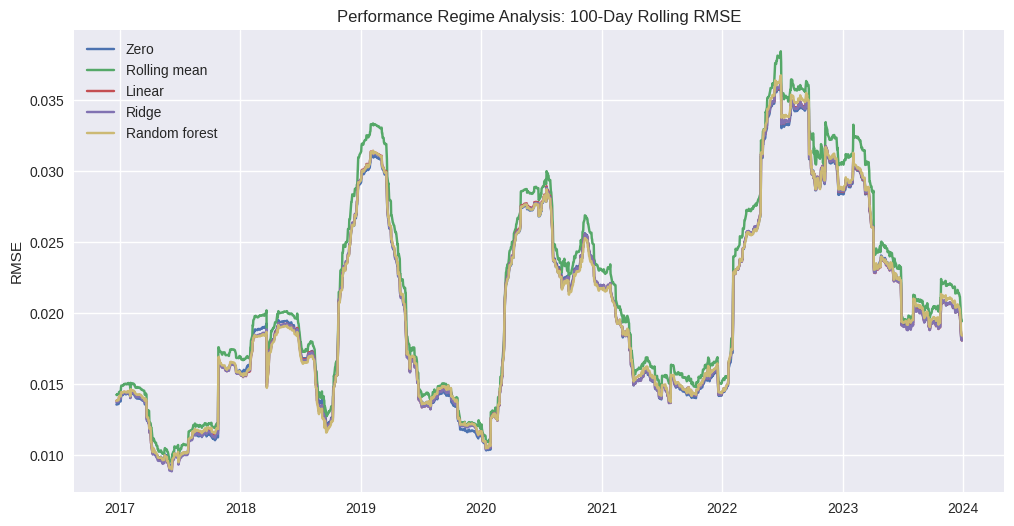

In [ ]:
# TODO: plot rolling RMSE vs time for all models to compare their performance across different time periods/regimes
def get_scaled_err(predictor, xt, yt, dates, nsplit=5):
    ts = TimeSeriesSplit(n_splits=nsplit)
    all_sq_errors = []
    all_indices = []
    
    for train_idx, test_idx in ts.split(xt):
        tr_x, tr_y = xt[train_idx], yt[train_idx]
        te_x, te_y = xt[test_idx], yt[test_idx]
        
        preds = predictor(te_x, train_x=tr_x, train_y=tr_y, test_y=te_y)
        
        sq_err = (preds - te_y)**2
        all_sq_errors.extend(sq_err)
        all_indices.extend(test_idx)
        
    return pd.Series(all_sq_errors, index=dates[all_indices])

model_errors = {}
for name, func in predictors:
    model_errors[name] = get_scaled_err(func, xt, yt, all_data.index)

plt.figure(figsize=(12, 6))
window = 100
for name, errors in model_errors.items():
    rolling_rmse = np.sqrt(errors.rolling(window).mean())
    plt.plot(rolling_rmse, label=name)

plt.title(f"Performance Regime Analysis: {window}-Day Rolling RMSE")
plt.ylabel("RMSE")
plt.legend()
plt.show()

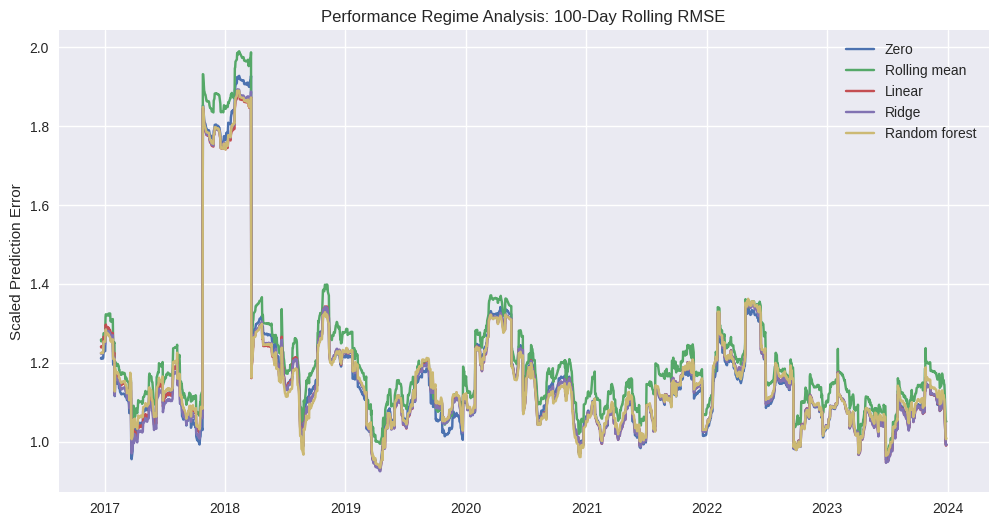

In [79]:
# Bonus: compute volatility scaled/normalized prediction error: sqrt( ((y_true - y_pred)**2) / (vol_t**2) ) - and compare across models
def get_scaled_err(predictor, xt, yt, dates, nsplit=5):
    ts = TimeSeriesSplit(n_splits=nsplit)
    all_sq_errors = []
    all_indices = []
    
    for train_idx, test_idx in ts.split(xt):
        tr_x, tr_y = xt[train_idx], yt[train_idx]
        te_x, te_y = xt[test_idx], yt[test_idx]
        
        preds = predictor(te_x, train_x=tr_x, train_y=tr_y, test_y=te_y)
        
        sq_err = (preds - te_y)**2 / (te_x[:, 3] ** 2)
        all_sq_errors.extend(sq_err)
        all_indices.extend(test_idx)
        
    return pd.Series(all_sq_errors, index=dates[all_indices])

model_errors = {}
for name, func in predictors:
    model_errors[name] = get_scaled_err(func, xt, yt, all_data.index)

plt.figure(figsize=(12, 6))
window = 100
for name, errors in model_errors.items():
    rolling_rmse = np.sqrt(errors.rolling(window).mean())
    plt.plot(rolling_rmse, label=name)

plt.title(f"Performance Regime Analysis: {window}-Day Rolling RMSE")
plt.ylabel("Scaled Prediction Error")
plt.legend()
plt.show()


## 9. Bonus: Looking at a toy strategy based on predictions
Define a simple "all-in" strategy where you go all long (+1) when you predict the stock to be going up, and all short (-1) when you predict the stock to be going down
$$
\text{position}_t = \text{sign}(y_\text{pred})
$$
Then, your returns for the $t$-th day (assuming daily returns) will be $(\text{position}_t \times y_\text{true})$ (note $y_\text{true} = r_t$).

Note that this is extremely simplistic and ignore any predictions related magnitude of expected returns, or expected volatility data etc. It is used only as a demonstration of what a prediction-based strategy may look like.

**Plot your returns using this strategy based on all the models above and compare them!**

In [80]:
# TODO: compute the positions for each model and daily returns
# I wanted to do this but the bad plots changed my mind :P anyway we will do it next week

In [ ]:
# TODO: plot your returns


## 10. Discussion questions

1. Why do we need naive baselines?
2. How does the evaluation strategy here (walk-forward evaluation) differ from the random training-test dataset splits used in convention ML?
3. *(Addon)* And, why does random splitting technique fail here?
4. Interpret the RMSE values and rolling RMSE plot results very briefly.
5. *(Addon)* Are there periods where model performance degrades noticeably? What might this indicate?
6. Why might Random Forest overfit?
7. *(Bonus)* Two models have similar RMSE, but one makes larger errors primarily during high-volatility periods. Why might this model be *less dangerous* in a portfolio context?

**Naive Baselines**  
We are building models that do not have any theoretical guarantees of correctness even though they might seem "resonable". As mentioned in the introduction, in practice it is extremely difficult to beat very simple / dumb-looking strategies. Therefore, we use baselines to judge whether the computation intensive strategies and those that are difficult to implement / maintain are worth using at all given their costs and profit margins.

**Dataset splitting Convention**  
The unique challenge that prediction models face is that in finance, not all data are equal unlike images, text, etc. Moreover, there are correlations in financial data that are stronger than corresponding correlations in other fields (e.g. if prices on day 3 are `<<` prices on day 1 then you know day 2 is probably somewhere in between). In real life, we do not know the farther future when we make predictions for tomorrow. Hence, it does not make any sense to train the machine on the future and ask about the present (a scenario which is very likely if we randomly split training and testing data).

**Interpreting plots**  
All the plots look nearly equal with small systematic differences. This means a small signal to noise ratio (~~or bugs in my code -- NEW YEAR EDITION~~).

**Random Forest overfit**  
They are highly flexible models and therefore prone to over-fitting. If a forest model is overfitting despite randomness, it may be due to consistent noisy trends in the data.

**Bonus**  
Since RMSE is same, this means lesser MSE than average in stable periods. 